This Jupyter Notebook contains the analysis of the Narrow Gait data that was collected in 2019. This notebook requires Jupyter and Python 3 to run the scripts. The easiest way to get it running is probably through downloading https://www.anaconda.com/products/individual

<b>Introduction</b>

-	Knee OA is a debilitating disease affecting a large proportion of older adults etc.
-	Gait retraining as a non-invasive intervention for reducing progression of knee OA by reducing first peak KAM.
-	Gait parameters which have previously shown promising decreases in first peak KAM namely FPA, trunk sway, and step width. 
-	Likewise, because of the promising results that gait modifications have on reducing first peak KAM, researchers have developed wearable sensors and feedback devices for the purposes of retraining these gait parameters outside a clinical laboratory setting.
-	As with many medical interventions, comfort and acceptance also need to be considered to ensure real-word efficacy and patient adoption outside laboratory settings.
-	Despite the effectiveness of modifying trunk lean on reducing first peak KAM, this modification has been seen as too unorthodox which may deter patient adherence [Mundermann 2008]. Caldwell et al. also found the trunk lean modification to require 11% more energy and 1178% more mental load compared with normal gait.
-	FPA has also been another well explored gait parameter leading to promising results in both healthy and patient populations. A recent study exploring the learning process of toe-in gait in patients with knee OA showed that in general, patients could reduce their FPA after six weeks, however some patients still found it difficult to achieve the target prescribed gait modifications without feedback. Additionally, Favre et al. reported an increase in peak knee flexion moment (KFM) during toe-in gait, which like peak KAM, is a measure associated with knee OA progression. 
-	The authors are interested in investigating gait modifications which can effectively reduce the first peak KAM without increasing peak KFM, and are easily adoptable. One gait modification that has had much less attention has been walking with a narrow gait. Although increased stride width has been shown to effectively reduce peak KAM, Donelan et al. showed that walking with an increased stride width (SW) increased the metabolic cost by 45% compared with normal gait, a narrow gait only contributed to an 8% increase. Presently, only two previous studies have investigated the decrease of step width and its relation to peak KAM during level walking. Street et al. found that walking with a narrow gait produced a reduction in the first peak KAM by 46% compared with normal walking. This reduction however, was restricted to the non-dominant limb and wasn’t observed in the dominant limb. Favre et al. investigated the influence of different combinations of FPA, step width, walking speed, and trunk sway on first KAM peak, KAM impulse, second KAM peak, and KFM peak along with additional insights into involuntary secondary gait modifications. It was found that a narrow gait modification actually increased first peak KAM, contrary to the findings by Street et al. Similarly, in Favre et al.’s study, adopting a narrow gait modification did not seem to invoke any involuntary secondary gait changes whereas Street et al. found that a narrow gait modification increased peak trunk sway towards the non-dominant limb. With such discrepancies in literature on the efficacy of decreasing step width as a gait modification and with increasing evidence of the need for patient specific modifications, it is possible that large variations exist between subject to subject.
-	The authors therefore sought to compare the first peak KAM and KFM of the dominant and non-dominant limbs of healthy subjects individually, while walking with narrow gait compared with normal gait whilst observing any involuntary secondary changes of the FPA, trunk sway, and walking speed. The purpose of this study is thus to determine: 

<b>Research Questions</b>

1.	Whether a narrow gait strategy can be used as a general peak KAM reduction modification or if it is only effective for a   proportion of the participants of the study for the dominant and non-dominant limbs separately.

2.	Whether walking with a narrow gait invokes any involuntary secondary gait modifications in any of the participants.

3.	If the narrow gait modification is not universally effective but is only applicable on certain participants, can these individuals be identified based on their biomechanical features. 


After collecting data from 16 participants walking at normal, wide, narrow and crossover gaits we create individual regression models to determine if how changes in step width (namely narrow and crossover gaits) affect the peak KAM while controlling for any secondary gait modifications like speed, trunk sway, and FPA.

<b>Results</b>

In [45]:
import pandas as pd
pd.set_option('display.max_columns', 10)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
#%matplotlib qt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, ElasticNetCV, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from statistics import mean
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

plt.rcParams.update({'font.size': 2})
matplotlib.rcParams['lines.linewidth'] = 0.1

Import CSV file as a dataframe containing all the variables for each subject at all four conditions

In [18]:
data = pd.read_csv('.\\CombinedData.csv')

In [19]:
data.head()

,FPAngleAtPKAM1,FPAngleAverage,KAMImpulse,KneeAbdAngleAverage,LimbPGRF1,LimbPGRF2,PKAM1,PKAM2,PKEM,PKFM,TLAngleAtPKAM1,Speed,Stride_Length_Mean,Stride_Width_Mean,Subject,Condition,Limb
0,-7.230547,-8.182900,0.062202,4.663079,1.115023,1.128372,0.182036,0.175094,0.264862,0.162476,2.856091,1.20477,1.34935,0.14251,0,Normal,Dominant
1,-8.612206,-10.070393,0.043692,3.562398,1.106193,1.137860,0.315429,0.036161,0.146773,0.308084,0.364802,1.41523,1.44353,0.17285,1,Normal,Dominant
2,-10.879077,-11.671491,0.046395,1.089170,1.112453,1.096914,0.129421,0.109493,0.315741,0.048201,0.902946,1.24310,1.35498,0.10087,2,Normal,Dominant
3,-7.176479,-8.006979,0.022724,-1.147855,1.155520,1.165713,0.206096,0.089303,0.040201,0.231571,5.465018,1.30053,1.36556,0.13726,3,Normal,Dominant
4,-9.464766,-9.667301,0.039445,1.563241,1.158450,1.119220,0.244285,0.091073,0.274727,0.168088,4.608932,1.37966,1.31068,0.06839,4,Normal,Dominant


We also want to import CSV files containing the Averaged Gait parameters for all five trials for each subject in the four different conditions. We will only use the average Step Width from the Crossover, Narrow, and Wide conditions in our regression equations along with the average trunk sway, FPA, and walking speed from Normal gait in our regression to determine what the effect is while controlling for secondary gait changes.

In [26]:
AverageNormDF = pd.read_csv('.\\AverageNormDF.csv')
AverageCrossoverDF = pd.read_csv('.\\AverageCrossoverDF.csv')
AverageNarrowDF = pd.read_csv('.\\AverageNarrowDF.csv')
AverageWideDF = pd.read_csv('.\\AverageWideDF.csv')

In order for us to create regression models with categorical features we have to convert create dummy variables.

In [30]:
EncodedDF = pd.get_dummies(data, columns=['Subject', 'Condition', 'Limb'])

In [31]:
EncodedDF.head()

,FPAngleAtPKAM1,FPAngleAverage,KAMImpulse,KneeAbdAngleAverage,LimbPGRF1,LimbPGRF2,PKAM1,PKAM2,PKEM,PKFM,...,Subject_12,Subject_13,Subject_14,Subject_15,Condition_Crossover,Condition_Narrow,Condition_Normal,Condition_Wide,Limb_Dominant,Limb_NonDominant
0,-7.230547,-8.182900,0.062202,4.663079,1.115023,1.128372,0.182036,0.175094,0.264862,0.162476,...,0,0,0,0,0,0,1,0,1,0
1,-8.612206,-10.070393,0.043692,3.562398,1.106193,1.137860,0.315429,0.036161,0.146773,0.308084,...,0,0,0,0,0,0,1,0,1,0
2,-10.879077,-11.671491,0.046395,1.089170,1.112453,1.096914,0.129421,0.109493,0.315741,0.048201,...,0,0,0,0,0,0,1,0,1,0
3,-7.176479,-8.006979,0.022724,-1.147855,1.155520,1.165713,0.206096,0.089303,0.040201,0.231571,...,0,0,0,0,0,0,1,0,1,0
4,-9.464766,-9.667301,0.039445,1.563241,1.158450,1.119220,0.244285,0.091073,0.274727,0.168088,...,0,0,0,0,0,0,1,0,1,0


<b>Creating the subject specific Ridge Regression models</b>

In [34]:
#Select subject
subject = list(EncodedDF.columns[14:30])
Dominant = 0 #Change to 1 for dominant limb

KAMarray = np.empty(0)
SubjectArray = np.zeros([1, 11])
for i in range(0, 16):
    SubjectDF = EncodedDF.loc[(EncodedDF[subject[i]]==1)&(EncodedDF['Limb_Dominant']==Dominant),:]
    
    Features = SubjectDF.loc[:, ['FPAngleAtPKAM1', 'TLAngleAtPKAM1', 'Speed', 'Stride_Width_Mean']]
    
    #Polynomial features order 2 with only interaction terms
    poly = PolynomialFeatures(2, interaction_only=True)
    PolyFeatures = poly.fit_transform(Features)
    
    #Standardize Features for Ridge Regression
    scaler = StandardScaler()
    scaler.fit(PolyFeatures)
    PolyFeatures = scaler.transform(PolyFeatures)
    
    #Target = SubjectDF.loc[:, 'PKFM']
    #Target = SubjectDF.loc[:, 'PKAM1']
    Target = SubjectDF.loc[:, 'KAMImpulse']
    
    #Perform GridsearchCV to determine alpha for Ridge
    parameters = {'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2, 2e-2, 4e-2, 1e-1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 100]}
    
    ridge = Ridge(max_iter=100000, normalize=True)
    ridgeCV = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=20)
    ridgeCV.fit(PolyFeatures, Target)
    
    ridgeReg = Ridge(alpha=ridgeCV.best_params_['alpha'], max_iter=100000, normalize=False)
    
    ridgeReg.fit(PolyFeatures, Target)
    
    print('Subject ' + str(i+1))
    print(ridgeReg.score(PolyFeatures, Target))
    print(ridgeReg.coef_)
#    
    SubjectArray = np.append(SubjectArray, [[ridgeReg.coef_[1], ridgeReg.coef_[2], ridgeReg.coef_[3], ridgeReg.coef_[4],
                                      ridgeReg.coef_[5], ridgeReg.coef_[6], ridgeReg.coef_[7], ridgeReg.coef_[8],
                                      ridgeReg.coef_[9], ridgeReg.coef_[10], ridgeReg.score(PolyFeatures, Target)]], axis = 0)
    
    NormalGait = AverageNormDF.loc[(AverageNormDF[subject[i]]==1)&(AverageNormDF['Limb_Dominant']==Dominant),
                                   ['FPAngleAtPKAM1', 'TLAngleAtPKAM1', 'Speed', 'Stride_Width_Mean']]
    
    CrossoverGait = AverageCrossoverDF.loc[(AverageCrossoverDF[subject[i]]==1)&(AverageCrossoverDF['Limb_Dominant']==Dominant),
                                   ['FPAngleAtPKAM1', 'TLAngleAtPKAM1', 'Speed', 'Stride_Width_Mean']]
    
    NarrowGait = AverageNarrowDF.loc[(AverageNarrowDF[subject[i]]==1)&(AverageNarrowDF['Limb_Dominant']==Dominant),
                                   ['FPAngleAtPKAM1', 'TLAngleAtPKAM1', 'Speed', 'Stride_Width_Mean']]
    
    WideGait = AverageWideDF.loc[(AverageWideDF[subject[i]]==1)&(AverageWideDF['Limb_Dominant']==Dominant),
                                   ['FPAngleAtPKAM1', 'TLAngleAtPKAM1', 'Speed', 'Stride_Width_Mean']]
    
    NewGait = NormalGait.loc[:,['FPAngleAtPKAM1', 'TLAngleAtPKAM1', 'Speed']]
    
    #Replace 'CrossoverGait/NarrowGait/WideGait with whichever condition you want to calculate KAM/KFM for
    NewGait = pd.concat([NewGait, WideGait.loc[:, 'Stride_Width_Mean']], axis=1)
    
    
    poly = PolynomialFeatures(2, interaction_only=True)
    PolyFeatures = poly.fit_transform(NewGait)
    
    #Scale NewGait
    PolyFeatures = scaler.transform(PolyFeatures)
    
    newKAM = ridgeReg.predict(PolyFeatures)
    print('Normal ' + str(newKAM))
    KAMarray = np.append(KAMarray, newKAM)

Subject 1
0.5628426927174229
[ 0.          0.00072614 -0.00201878 -0.04010063 -0.02555569 -0.00031666
  0.00061719  0.00943076 -0.00170024  0.00584661 -0.02064753]
Normal [0.23782986]
Subject 2
0.3490149606303171
[ 0.00000000e+00 -7.76836667e-04 -1.15931653e-04  5.36742813e-02
 -8.85081665e-03 -2.50358290e-04 -5.85736136e-04 -2.86108644e-03
 -7.26087451e-06 -1.84864740e-03 -2.20406620e-03]
Normal [0.27374685]
Subject 3
0.629124021425523
[ 0.00000000e+00  5.15616203e-05 -1.04666261e-02 -1.34034946e-02
 -3.31441217e-02 -1.63128039e-03  7.58392177e-05  7.45144730e-03
  1.88356012e-04 -8.44971685e-04 -1.26641573e-03]
Normal [0.31131776]
Subject 4
0.7619047002808671
[ 0.         -0.00052876 -0.00203709  0.0246545  -0.02798783 -0.00080312
  0.00119984 -0.01358901 -0.00235544 -0.00793122 -0.00535261]
Normal [0.21601817]
Subject 5
0.6839440316758592
[ 0.00000000e+00 -1.35570225e-03 -5.44317906e-03  3.71886838e-04
 -8.47223366e-02  6.41854717e-05 -9.35133706e-04 -1.64004357e-03
 -5.07595167e-03

Using 'Subject 16' as an example:

Subject 16
0.6406525020427836 (this is the R2 value from the regression model)

[ 0.         -0.00093773 -0.00504389  0.06947925 -0.03289207 -0.00024753
 -0.00116477  0.01129839 -0.00397843  0.00983938 -0.0409931 ] (these are the regression coefficients)
 
 Normal [0.24556806] (This is the predicted KAM/KFM value for the particular condition you selected in the variable 'NewGait' above while controlling for secondary gait changes ie. using the Normal FPA, Trunk sway, and walking speeds in the regression model)

<b>These models have been pre-generated and saved in the excel spreadsheet RegressionCoefficients.xlsx in the same directory.</b> 

From the predicted KAM/KFM values etc. we can use bootstrapping to perform a one sample hypothesis test ie. whether or not there is a difference between the predicted value and the KAM/KFM from the subject's normal gait (5 samples) (see page 224 from Efron, Bradley, and Robert J. Tibshirani. An introduction to the bootstrap. CRC press, 1994. for method used).

<b>The script below performs this analysis, the results are also already pre-generated in RegressionCoefficients.xlsx</b>

In [35]:
#Function which performs the one sample bootstrap hypothesis test
def bootstrapTest(dataframe, testValue, samples=10000):
    difference = np.empty(0)
    meanDiffObs = abs(mean(dataframe) - testValue)
    newData = np.array(dataframe) - mean(dataframe) + float(testValue)
    
    for i in range(0, 10000):
        newSample = np.random.choice(newData, size=5)
        Diff = abs(mean(newSample) - float(testValue))
        difference = np.append(difference, float(Diff))
    
    p_value = len(difference[difference>float(meanDiffObs)])/(samples)
    
    return p_value
    
    
controlledDF = pd.read_csv(".\\ControlledKFM.csv") #You can replace this with 'ControlledKAM.csv' etc. 
controlledDF = pd.get_dummies(controlledDF, columns=['Subject'])
controlledDF = controlledDF.loc[(controlledDF['Limb_Dominant']==0),:]
NormalDF = EncodedDF.loc[(EncodedDF['Condition_Normal']==1)&(EncodedDF['Limb_Dominant']==0),:]

subject = list(EncodedDF.columns[14:30])
crossoverPValue = np.empty(0)
narrowPValue = np.empty(0)
widePValue = np.empty(0)
for i in range(0, 16):
    subjectNormal = NormalDF.loc[NormalDF[subject[i]]==1, 'PKFM']
    
    #Perform bootstrap hypothesis test
    p_value = bootstrapTest(subjectNormal, controlledDF.loc[controlledDF[subject[i]]==1, 'Crossover'])
    crossoverPValue = np.append(crossoverPValue, p_value)
    
    p_value = bootstrapTest(subjectNormal, controlledDF.loc[controlledDF[subject[i]]==1, 'Narrow'])
    narrowPValue = np.append(narrowPValue, p_value)
    
    p_value = bootstrapTest(subjectNormal, controlledDF.loc[controlledDF[subject[i]]==1, 'Wide'])
    widePValue = np.append(widePValue, p_value)

<b>Tables below show the means and results of the one sample test, green means the mean was higher than Normal gait (p < 0.05) and bold means the mean was lower than Normal gait (p < 0.05)</b>

<img src="./KAM_Dominant.png">

<img src="./KAM_NonDominant.png">

<img src="./KFM_Dominant.png">

<img src="./KFM_NonDominant.png">

<img src="./Impulse_Dominant.png">

<img src="./Impulse_NonDominant.png">

Based on the results above it seems that when you control for secondary gait modifications, crossover and narrow gait interventions don't seem to be very effective when compared with Wide gait. The only subjects that seemed to still experience an improvement with crossover or narrow gait were subject 4 (dominant limb) and subject 10 (dominant limb).

<b>Even though the reduction in the step width of the Crossover gait may not be the parameter which is reducing the KAM, if we use it as a means to influence a secondary gait parameter e.g. reducing walking speed, it may still be an interesting strategy which may not require any wearable devices at all seeing as a person can easily walk with a crossover gait just by visually aligning their own foot steps.</b>

We can generate correlation matrices between Step Width/Stride Width and the other secondary gait parameters for each subject: FPA, Trunk lean and Speed. 

In [39]:
#Segment into Dominant/Nondominant and then conditions
DomDF = EncodedDF.loc[EncodedDF["Limb_Dominant"]==1, :]
NonDomDF = EncodedDF.loc[EncodedDF["Limb_NonDominant"]==1, :]

#Generate correlation matrices for each subject for dominant and non-dominant limbs separately
MatrixArrayDom = []
MatrixArrayNon = []

for i in range(0, 16):
    print("Subject "+str(i))
    print("Dominant: ")
    tempDom = DomDF.loc[DomDF["Subject_"+str(i)]==1, ["FPAngleAtPKAM1", "TLAngleAtPKAM1", "Speed", "Stride_Width_Mean"]].corr()
    print(tempDom)
    print("\n")
    print("Non-Dominant: ")
    tempNonDom = NonDomDF.loc[NonDomDF["Subject_"+str(i)]==1, ["FPAngleAtPKAM1", "TLAngleAtPKAM1", "Speed", "Stride_Width_Mean"]].corr()
    print(tempNonDom)
    print("\n")
    
    MatrixArrayDom.append(tempDom.iloc[3, :3])
    MatrixArrayNon.append(tempNonDom.iloc[3, :3])

Subject 0
Dominant: 
                   FPAngleAtPKAM1  TLAngleAtPKAM1     Speed  Stride_Width_Mean
FPAngleAtPKAM1           1.000000       -0.092214 -0.342453          -0.751160
TLAngleAtPKAM1          -0.092214        1.000000  0.188347           0.376003
Speed                   -0.342453        0.188347  1.000000           0.443836
Stride_Width_Mean       -0.751160        0.376003  0.443836           1.000000


Non-Dominant: 
                   FPAngleAtPKAM1  TLAngleAtPKAM1     Speed  Stride_Width_Mean
FPAngleAtPKAM1           1.000000       -0.542390 -0.356050          -0.812143
TLAngleAtPKAM1          -0.542390        1.000000  0.053022           0.358535
Speed                   -0.356050        0.053022  1.000000           0.456965
Stride_Width_Mean       -0.812143        0.358535  0.456965           1.000000


Subject 1
Dominant: 
                   FPAngleAtPKAM1  TLAngleAtPKAM1     Speed  Stride_Width_Mean
FPAngleAtPKAM1           1.000000       -0.544497 -0.450517          -

We can see that each subject differs in how their secondary gait parameters correlates with stride width.

<b>Using these correlation values along with the subject's height and weight as features, then performing PCA and visualizing it on a 2D scatter plot</b>

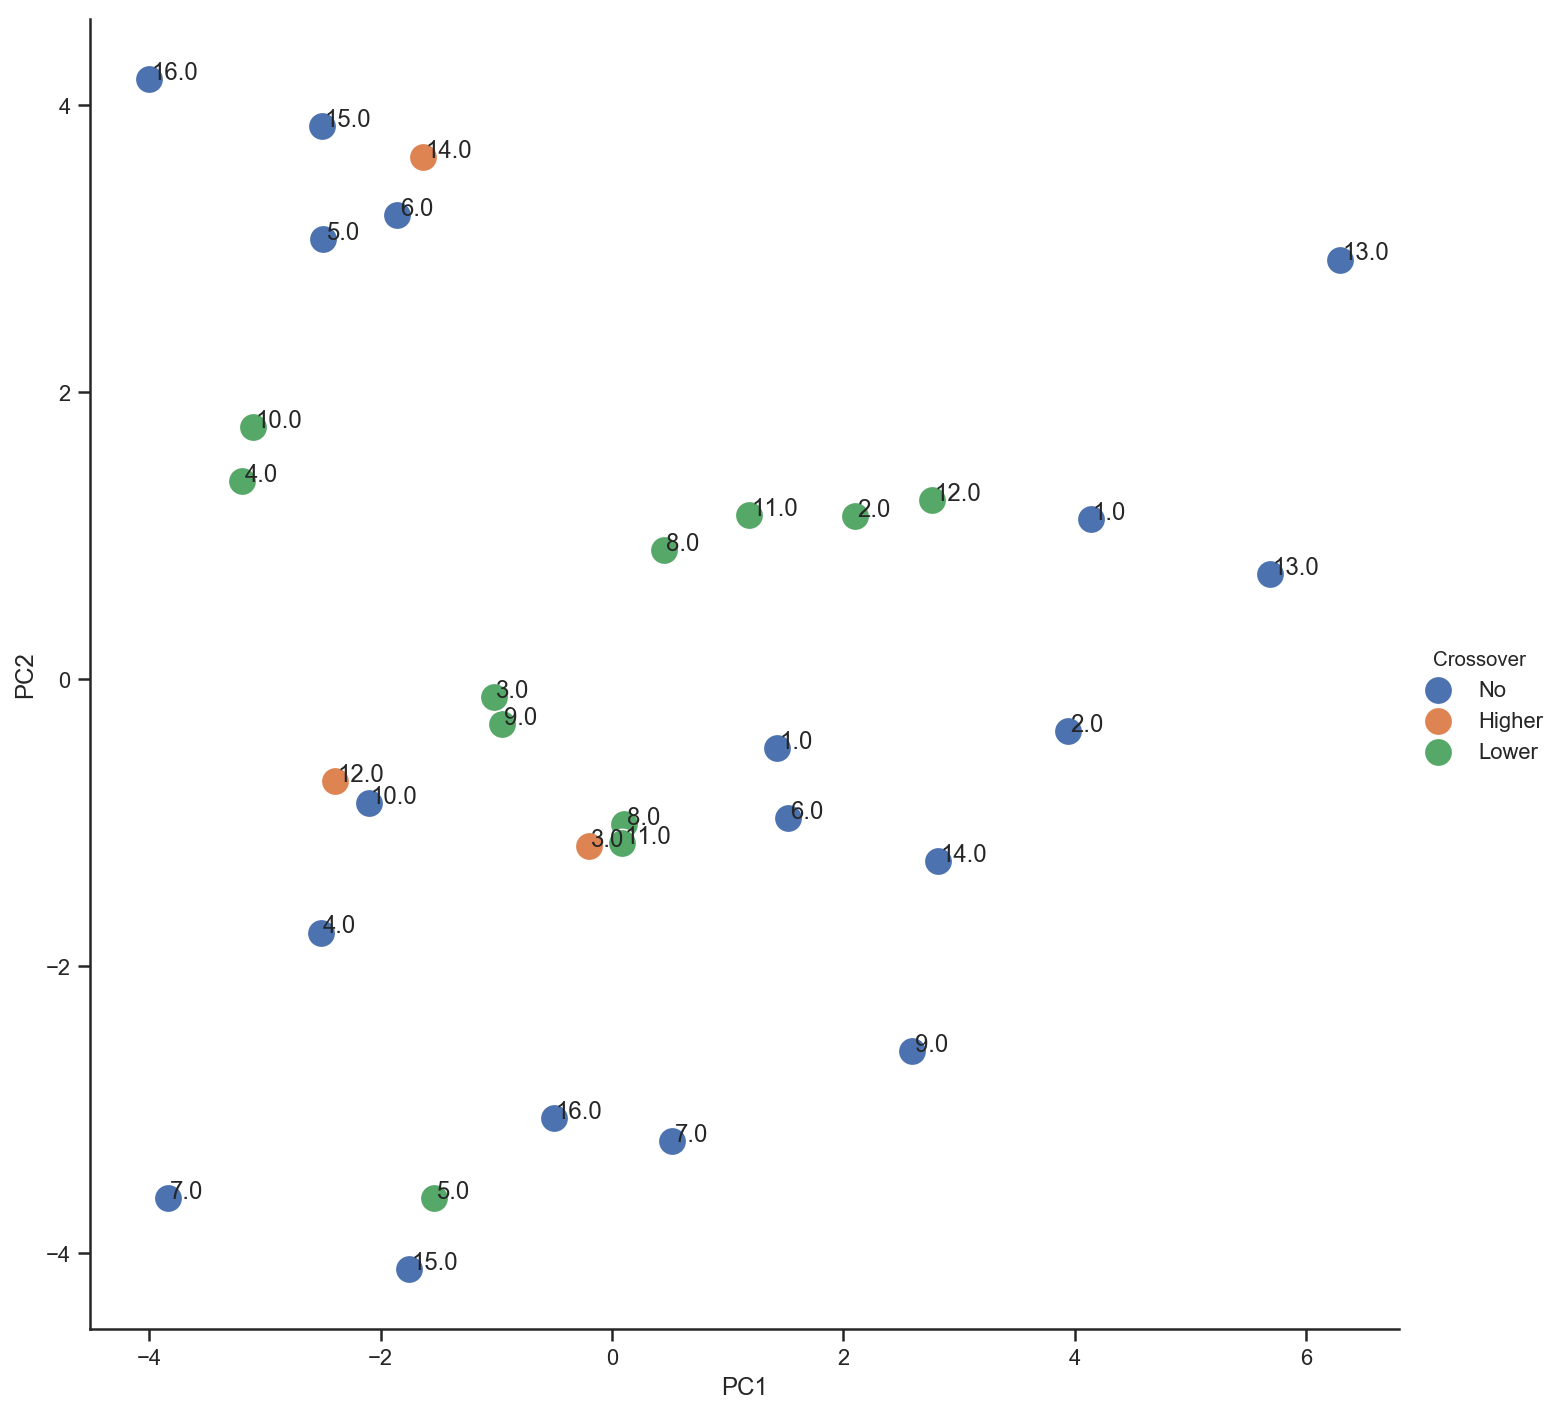

In [46]:
#Build dataframe of correlation coefficients
MatrixDomDF = pd.DataFrame(pd.concat(MatrixArrayDom, axis=1)).transpose()

DominantLimb = np.ones(shape=16)
DominantLimb = np.append(DominantLimb, np.zeros(shape=16))
LimbSeries = pd.Series(data=DominantLimb, name='Limb')

Subject = np.array(range(1, 17))
Subject = np.append(Subject, Subject)
SubjectSeries = pd.Series(data=Subject, name='Subject')

MatrixNonDomDF = pd.DataFrame(pd.concat(MatrixArrayNon, axis=1)).transpose()

MatrixDF = pd.concat([MatrixDomDF, MatrixNonDomDF], axis=0).reset_index(drop=True)

#Include height and weight of subjects in dataframe
HeightWeightDF = pd.read_csv(".\\HeightWeight.csv")
HeightWeightDF = pd.concat([HeightWeightDF, HeightWeightDF], axis = 0).reset_index(drop=True)

MatrixDF = pd.concat([MatrixDF, HeightWeightDF], axis = 1)
MatrixDF = pd.concat([MatrixDF, LimbSeries], axis=1)


"""Perform PCA on FPA, TL, and Speed and visualize on 2D scatter plot"""
FeaturesDom = MatrixDF.loc[MatrixDF['Limb']==1, :'Height']
FeaturesNonDom = MatrixDF.loc[MatrixDF['Limb']==0, :'Height']

polyFeaturesDom = PolynomialFeatures(2)
polyFeaturesDom = polyFeaturesDom.fit_transform(FeaturesDom)

polyFeaturesNonDom = PolynomialFeatures(2)
polyFeaturesNonDom = polyFeaturesNonDom.fit_transform(FeaturesNonDom)

PCAFeaturesDom = StandardScaler().fit_transform(polyFeaturesDom)
PCAFeaturesNonDom = StandardScaler().fit_transform(polyFeaturesNonDom)

pca = PCA(n_components=2)
pComponentsDom = pca.fit_transform(PCAFeaturesDom)
pComponentsNonDom = pca.fit_transform(PCAFeaturesNonDom)

#Recombine with Dominant limb and Subject columns
pcaDomDF = pd.DataFrame(pComponentsDom, columns=['PC1', 'PC2'])
pcaNonDomDF = pd.DataFrame(pComponentsNonDom, columns=['PC1', 'PC2'])
pcaDF = pd.concat([pcaDomDF, pcaNonDomDF], axis=0).reset_index(drop=True)
pcaDF = pd.concat([pcaDF, LimbSeries, SubjectSeries], axis=1)

GaitMod_DomDF = pd.read_csv(".\\GaitModificationKAM_HigherLowerNo_Dom.csv")
GaitMod_NonDomDF = pd.read_csv(".\\GaitModificationKAM_HigherLowerNo_NonDom.csv")

GaitModDF = pd.concat([GaitMod_DomDF, GaitMod_NonDomDF], axis = 0).reset_index(drop=True)

pcaDF = pd.concat([pcaDF, GaitModDF], axis = 1)


#2D scatterplot with colours for each subject and limb
Limb = 1
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=pcaDF, x_vars=['PC1'], y_vars=['PC2'], hue='Crossover', height=10, plot_kws={"s": 200})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(pcaDF.PC1, pcaDF.PC2, pcaDF.Subject, plt.gca())  
plt.show()




In this plot, 'No' means there was no difference in KAM between crossover gait compared with normal gait (not controlling for secondary effects). Likewise, 'higher' means crossover gait had a higher KAM than normal gait, and 'lower' means crossover gait had a lower KAM than normal gait. Text labels show the individual subjects. This table shows both dominant and non dominant limbs.

<b>It seems that there is a region in the center (green) where subjects with a certain correlation between their Stride Width, Speed, Trunk lean, along with their particular height and weight get a reduction in their KAM. This means it could be possible to identify subjects who may benefit from crossover gait as a strategy for reducing KAM ie. subjects who change their secondary gait parameters in a way which reduces their KAM indirectly via a crossover gait.</b>